In [ ]:
# !pip install stable-baselines3[extra]
# !pip install gymnasium


In [ ]:
import numpy as np
from gymnasium import Env, spaces

class UserAppEnv(Env):
    def __init__(self):
        super().__init__()

        self.action_space = spaces.Discrete(2)
        self.fogg_logs = []

        self.observation_space = spaces.MultiDiscrete([
            24,  # hora do dia
            7,   # dia da semana
            3,   # motivação
            3,   # habilidade
            11,  # vezes abriu app
            61,  # tempo total no app
            2,   # completou tarefa
            2    # notificado
        ])

        self.reset()
        self.completadas_dia = 0 # Initialize completadas_dia

    def reset(self, seed=None, options=None):
        self.hora = 8
        self.dia = 0  # Segunda-feira
        self.motivacao = 1
        self.habilidade = 1
        self.vezes_abriu = 0
        self.tempo_total = 0
        self.completou = 0
        self.notificado = 0
        self.passos = 0
        self.completadas_dia = 0 # Reset completadas_dia
        return self._get_obs(), {}

    def _get_obs(self):
        return np.array([
            self.hora,
            self.dia,
            self.motivacao,
            self.habilidade,
            min(self.vezes_abriu, 10),
            min(self.tempo_total, 60),
            self.completou,
            self.notificado
        ])

    def step(self, action):
      reward = 0
      self.notificado = 0  # começa como não notificado neste passo

      if action == 1:
          self.notificado = 1
          if self._usuario_abriu_app():
              self.vezes_abriu += 1
              duracao = np.random.randint(1, 15)
              self.tempo_total += duracao
              self.completou = self._fogg_model()
              reward = 5 if self.completou else self._penalidade_contextual()
          else:
              self.completou = 0
              reward = -1  # penaliza notificação ignorada
      else:
          self.completou = 0

      # 📌 LOG do ponto FBM
      if self.notificado:
          self.fogg_logs.append({
              "motivacao": self.motivacao,
              "habilidade": self.habilidade,
              "completou": self.completou,
              "notificado": self.notificado
          })

      self._update_user_state()

      self.passos += 1
      self.hora += 1

      # Avança para o próximo dia
      novo_dia = False
      if self.hora >= 24:
          self.hora = 0
          self.dia = (self.dia + 1) % 7
          self.vezes_abriu = 0
          self.tempo_total = 0
          self.completadas_dia = 0
          novo_dia = True

      terminated = self.passos >= 24 * 7  # uma semana simulada
      truncated = False

      return self._get_obs(), reward, terminated, truncated, {}




    def _fogg_model(self):
        return self.motivacao * self.habilidade >= 2

    def _update_user_state(self):
        # Interligação com variáveis
        # 1. Completou a tarefa → reforço positivo
        if self.completou:
            self.motivacao = min(self.motivacao + 1, 2)
            self.habilidade = min(self.habilidade + 1, 2)

        # 2. Tentou mas falhou → frustração
        elif self.vezes_abriu > 0:
            self.motivacao = max(self.motivacao - 1, 0)
            self.habilidade = max(self.habilidade - 1, 0)

        # 3. Não tentou → flutuação leve por contexto (hora e dia)
        else:
            # Exemplo: motivação maior pela manhã, menor à noite
            if 6 <= self.hora < 10:
                self.motivacao = min(self.motivacao + 1, 2)
            elif 21 <= self.hora <= 23:
                self.motivacao = max(self.motivacao - 1, 0)

            # Exemplo: habilidade menor nos fins de semana (distração)
            if self.dia >= 5:
                self.habilidade = max(self.habilidade - 1, 0)
            else:
                self.habilidade = np.clip(self.habilidade + np.random.choice([-1, 0, 1]), 0, 2)

    def _penalidade_contextual(self):
      """
      Penaliza mais conforme o número de notificações aumenta no mesmo dia.
      Simula "irritação" do usuário por excesso de prompts.
      """
      if self.vezes_abriu <= 2:
          return -2  # erro leve
      elif self.vezes_abriu <= 4:
          return -4  # erro moderado
      else:
          return -10  # erro grave, já abusou da paciência do usuário

    def _usuario_abriu_app(self):
      """
      Retorna True se o usuário abriu o app após notificação,
      considerando motivação, hora e saturação.
      """
      base_prob = 0.2 + 0.2 * self.motivacao  # motivação influencia
      if self.hora >= 22 or self.hora <= 6:
          base_prob -= 0.3  # menos provável abrir de madrugada

      if self.vezes_abriu >= 5:
          base_prob -= 0.2  # saturação: muitas notificações no mesmo dia

      base_prob = max(0, min(base_prob, 1))
      return np.random.rand() < base_prob


In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

env = UserAppEnv()
check_env(env, warn=True)

#Treinar agente com PPO
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=20000)

#Testar agente após treinamento
obs, _ = env.reset()
done = False
total_reward = 0

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

print("🎉 Recompensa total no teste:", total_reward)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 168      |
|    ep_rew_mean     | -85.3    |
| time/              |          |
|    fps             | 931      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 168         |
|    ep_rew_mean          | -75         |
| time/                   |             |
|    fps                  | 673         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016775347 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss   

In [ ]:
import matplotlib.pyplot as plt

# Armazena a recompensa média a cada N timesteps
def treinar_com_monitoramento(env, total_timesteps=20000, log_interval=1):
    model = PPO("MlpPolicy", env, verbose=0)
    mean_rewards = []

    for i in range(0, total_timesteps, 2048):  # 2048 é o default do PPO rollout
        model.learn(total_timesteps=2048, reset_num_timesteps=False)


        # Avalia após cada treino
        mean_reward = avaliar_agente(model, env)
        mean_rewards.append(mean_reward)
        print(f"✅ Passo {i+2048}: Média de recompensa no teste = {mean_reward}")
    return model, mean_rewards


def avaliar_agente(model, env):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward
    return total_reward


# Estratégia heurística: sempre notificar se não for à noite (21h às 6h)
def agente_heuristico(env):
    obs, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        hora = obs[0]
        notificar = 1 if (6 <= hora <= 20) else 0
        action = notificar
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward
    return total_reward


✅ Passo 2048: Média de recompensa no teste = 0
✅ Passo 4096: Média de recompensa no teste = 0
✅ Passo 6144: Média de recompensa no teste = 0
✅ Passo 8192: Média de recompensa no teste = 0
✅ Passo 10240: Média de recompensa no teste = 25
✅ Passo 12288: Média de recompensa no teste = 65
✅ Passo 14336: Média de recompensa no teste = 34
✅ Passo 16384: Média de recompensa no teste = 66
✅ Passo 18432: Média de recompensa no teste = 48
✅ Passo 20480: Média de recompensa no teste = 36


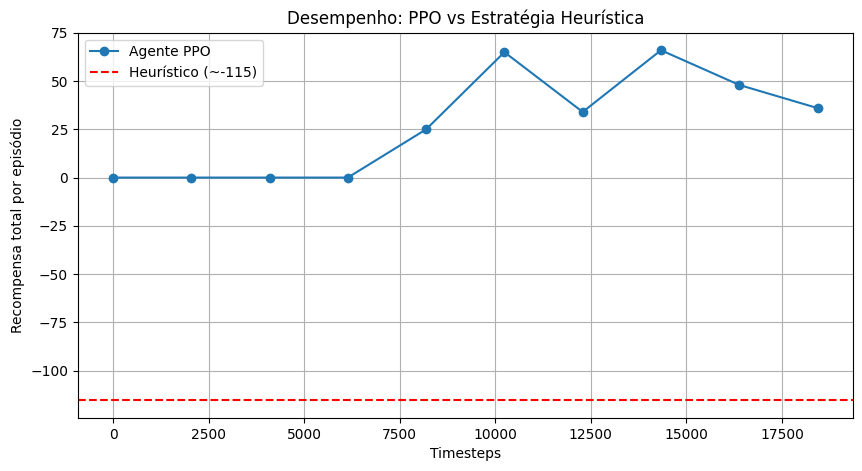

In [ ]:

env = UserAppEnv()

# Treina o agente PPO com monitoramento
ppo_model, rewards_ppo = treinar_com_monitoramento(env, total_timesteps=20000)

# Avalia estratégia heurística
heuristic_rewards = []
for _ in range(10):
    r = agente_heuristico(UserAppEnv())
    heuristic_rewards.append(r)
mean_heuristic = np.mean(heuristic_rewards)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(rewards_ppo)) * 2048, rewards_ppo, label="Agente PPO", marker="o")
plt.axhline(y=mean_heuristic, color='r', linestyle='--', label=f"Heurístico (~{mean_heuristic:.0f})")
plt.xlabel("Timesteps")
plt.ylabel("Recompensa total por episódio")
plt.title("Desempenho: PPO vs Estratégia Heurística")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Roda o agente por 1 semana simulada (168 passos) e registra cada ação
def rodar_politica_e_coletar(model, env):
    obs, _ = env.reset()
    done = False

    notificacoes_por_dia = []
    notificacoes_por_hora = [0] * 24
    completadas_por_hora = [0] * 24

    notificacoes_dia_atual = 0
    dia_atual = 0

    fogg_logs = env.fogg_logs


    while not done:
        hora = obs[0]
        dia = obs[1]

        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = env.step(action)

        # Coleta dados
        if action == 1:
            notificacoes_por_hora[hora] += 1
            notificacoes_dia_atual += 1
            if obs[6] == 1:  # completou tarefa
                completadas_por_hora[hora] += 1

        # Avança para novo dia
        if dia != dia_atual:
            notificacoes_por_dia.append(notificacoes_dia_atual)
            notificacoes_dia_atual = 0
            dia_atual = dia


    #Adiciona o último dia
    notificacoes_por_dia.append(notificacoes_dia_atual)

    return notificacoes_por_dia, notificacoes_por_hora, completadas_por_hora, fogg_logs # Return fogg_logs

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128276 (\N{BELL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


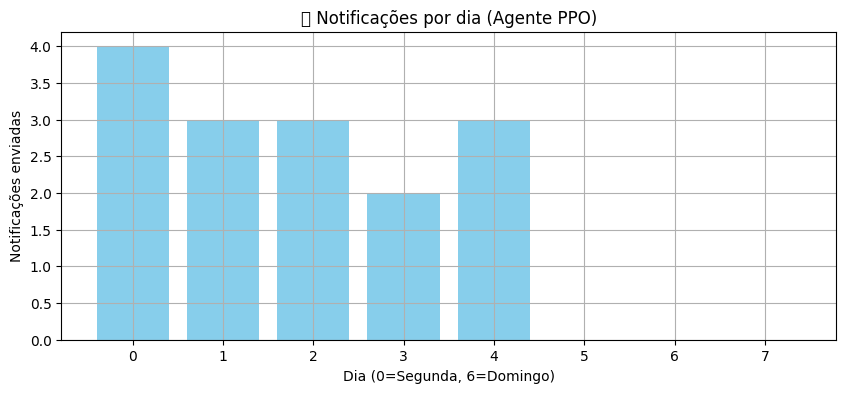

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


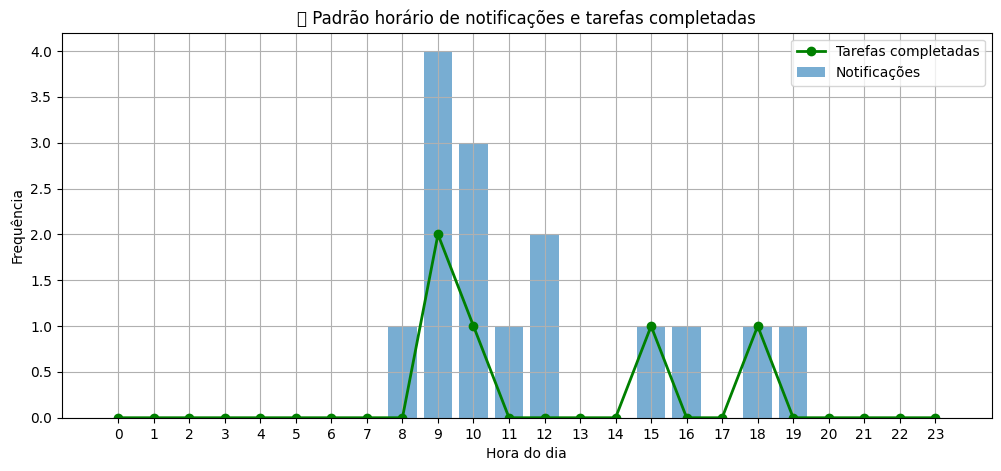

In [ ]:
#coleta
notificacoes_dia, notificacoes_hora, completadas_hora, fogg_logs_unused = rodar_politica_e_coletar(ppo_model, UserAppEnv())

# Gráfico 1: Notificações por dia
plt.figure(figsize=(10, 4))
plt.bar(range(len(notificacoes_dia)), notificacoes_dia, color="skyblue")
plt.xlabel("Dia (0=Segunda, 6=Domingo)")
plt.ylabel("Notificações enviadas")
plt.title("🔔 Notificações por dia (Agente PPO)")
plt.grid(True)
plt.show()

# Gráfico 2: Notificações e Tarefas Completadas por Hora
plt.figure(figsize=(12, 5))
plt.bar(range(24), notificacoes_hora, label="Notificações", alpha=0.6)
plt.plot(range(24), completadas_hora, label="Tarefas completadas", color="green", linewidth=2, marker="o")
plt.xticks(range(24))
plt.xlabel("Hora do dia")
plt.ylabel("Frequência")
plt.title("⏰ Padrão horário de notificações e tarefas completadas")
plt.legend()
plt.grid(True)
plt.show()

Heatmap (hora x intervenção)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


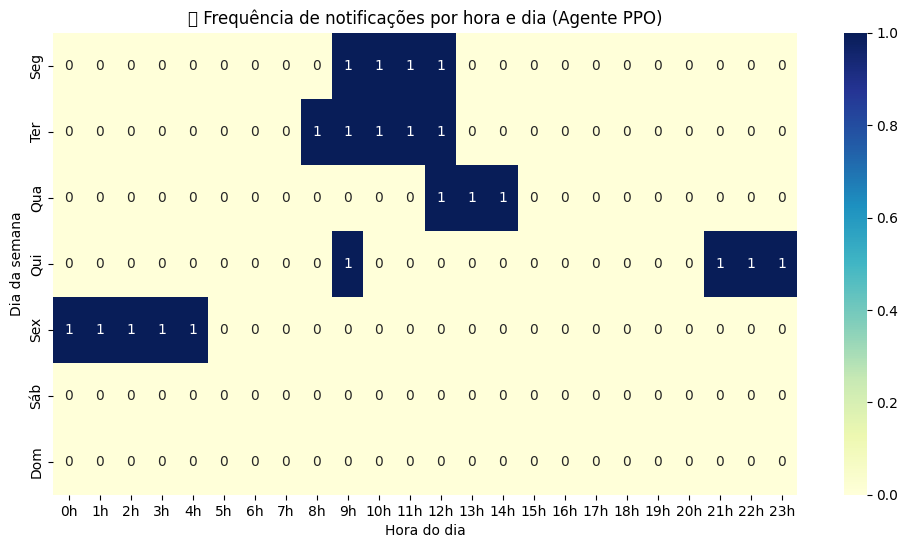

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def rodar_politica_com_heatmap(model, env):
    obs, _ = env.reset()
    done = False

    # Matriz 7 (dias) × 24 (horas)
    heatmap = np.zeros((7, 24))

    while not done:
        hora = obs[0]
        dia = obs[1]

        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = env.step(action)

        if action == 1:
            heatmap[dia][hora] += 1

    return heatmap

heatmap = rodar_politica_com_heatmap(ppo_model, UserAppEnv())

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap, annot=True, fmt=".0f", cmap="YlGnBu", cbar=True,
            xticklabels=[f"{h}h" for h in range(24)],
            yticklabels=["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"])
plt.title("🔥 Frequência de notificações por hora e dia (Agente PPO)")
plt.xlabel("Hora do dia")
plt.ylabel("Dia da semana")
plt.show()


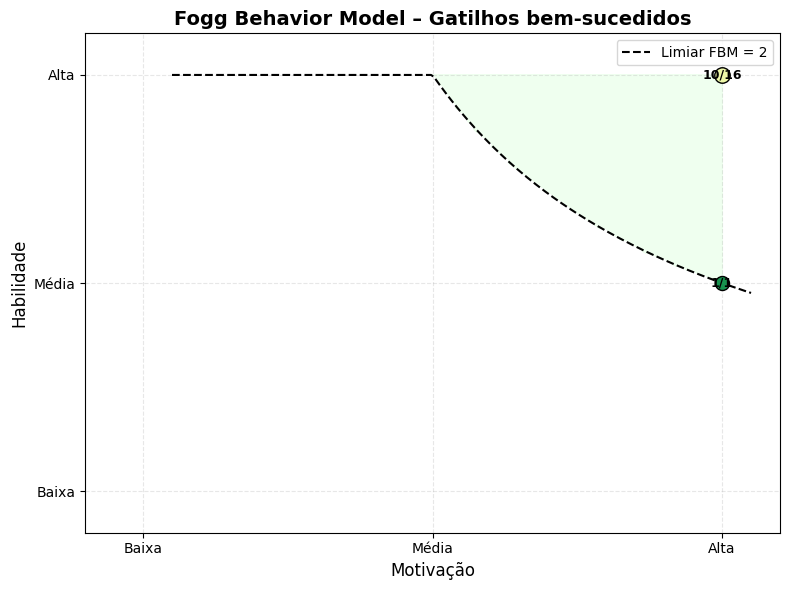

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns

# Agrupar dados
counts = defaultdict(lambda: [0, 0])
for d in fogg_logs:
    if d["notificado"] == 1:
        key = (d["motivacao"], d["habilidade"])
        counts[key][1] += 1
        counts[key][0] += d["completou"]

# Configuração do gráfico
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Fogg Behavior Model – Gatilhos bem-sucedidos", fontsize=14, weight="bold")

# Mapeamento de nomes
label_m = {0: "Baixa", 1: "Média", 2: "Alta"}
label_h = {0: "Baixa", 1: "Média", 2: "Alta"}

# Sombra de região "sucesso esperado"
m_grid, h_grid = np.meshgrid(np.linspace(0, 2, 100), np.linspace(0, 2, 100))
fbm_threshold = m_grid * h_grid >= 2
ax.contourf(m_grid, h_grid, fbm_threshold, levels=[0.5, 1], colors=["#e0ffe0"], alpha=0.5)

# Plotar bolhas
for (m, h), (completou, total) in counts.items():
    taxa = completou / total if total > 0 else 0
    cor = sns.color_palette("RdYlGn", 10)[int(taxa * 9)]
    ax.scatter(m, h, s=100 + total * 1.5, color=cor, edgecolor='black', zorder=3)
    ax.text(m, h, f"{completou}/{total}", ha='center', va='center', fontsize=9, weight='bold', zorder=4)

# Curva do limiar FBM = 2
x_vals = np.linspace(0.1, 2.1, 200)
y_vals = 2 / x_vals
y_vals = np.clip(y_vals, 0, 2)
ax.plot(x_vals, y_vals, 'k--', label="Limiar FBM = 2", zorder=2)

# Eixos e rótulos
ax.set_xticks([0, 1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xticklabels(["Baixa", "Média", "Alta"])
ax.set_yticklabels(["Baixa", "Média", "Alta"])
ax.set_xlabel("Motivação", fontsize=12)
ax.set_ylabel("Habilidade", fontsize=12)
ax.legend(loc="upper right")
ax.set_xlim(-0.2, 2.2)
ax.set_ylim(-0.2, 2.2)
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()



**Classe personalizada de usuário com comportamento específico (responde apenas em terças e quintas)**


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


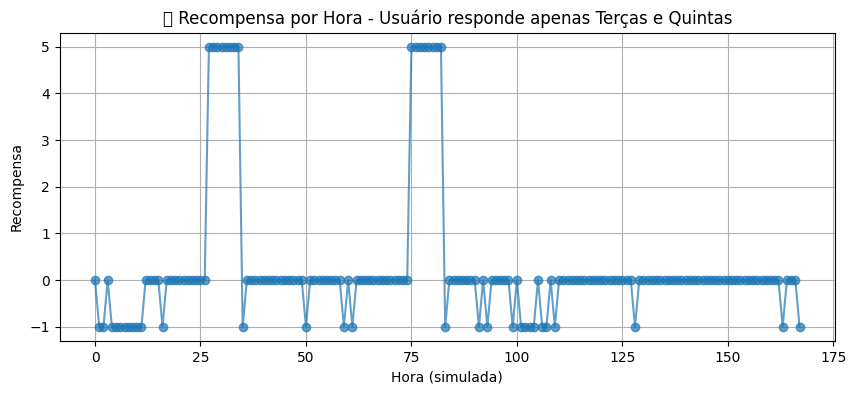

In [ ]:

class PerfilUsuarioTerQui(UserAppEnv):
    def _usuario_abriu_app(self):
        """
        O usuário só responde positivamente à notificação se for terça (dia=1) ou quinta (dia=3)
        e se estiver dentro de uma janela aceitável de horário.
        """
        if self.dia in [1, 3] and 8 <= self.hora <= 18:
            return True  # sempre responde nessas condições
        return False  # ignora notificações em outros dias/horários

#ambiente com perfil customizado
perfil_terqui_env = PerfilUsuarioTerQui()



obs, _ = perfil_terqui_env.reset()
rewards = []
for _ in range(7 * 24):                              # 1 semana (24h * 7 dias)
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = perfil_terqui_env.step(action)
    rewards.append(reward)
    if done:
        break

plt.figure(figsize=(10, 4))
plt.plot(rewards, marker='o', alpha=0.7)
plt.title("🎯 Recompensa por Hora - Usuário responde apenas Terças e Quintas")
plt.xlabel("Hora (simulada)")
plt.ylabel("Recompensa")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127749 (\N{SUNRISE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


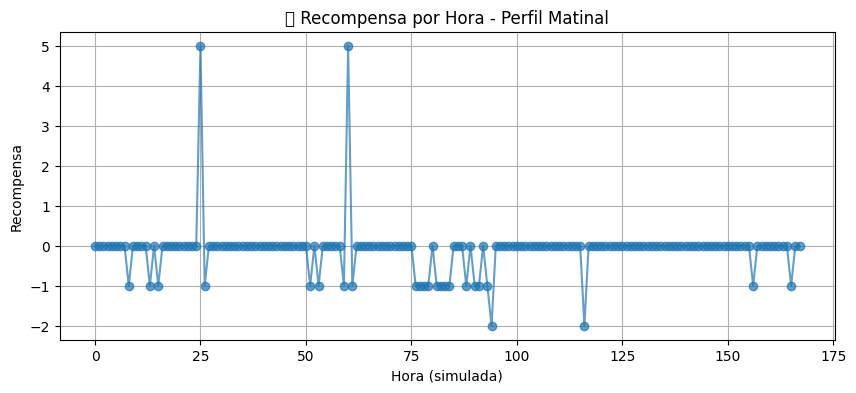

In [ ]:
class PerfilMatinal(UserAppEnv):
    def _usuario_abriu_app(self):
        if 6 <= self.hora <= 9:
            return True
        return np.random.rand() < 0.1

env_matinal = PerfilMatinal()
obs, _ = env_matinal.reset()
rewards = []

for _ in range(7 * 24):                                             #7 dias × 24h
    action, _ = model.predict(obs)
    obs, reward, terminated, _, _ = env_matinal.step(action)
    rewards.append(reward)
    if terminated:
        break

plt.figure(figsize=(10, 4))
plt.plot(rewards, marker='o', alpha=0.7)
plt.title("🌅 Recompensa por Hora - Perfil Matinal")
plt.xlabel("Hora (simulada)")
plt.ylabel("Recompensa")
plt.grid(True)
plt.show()


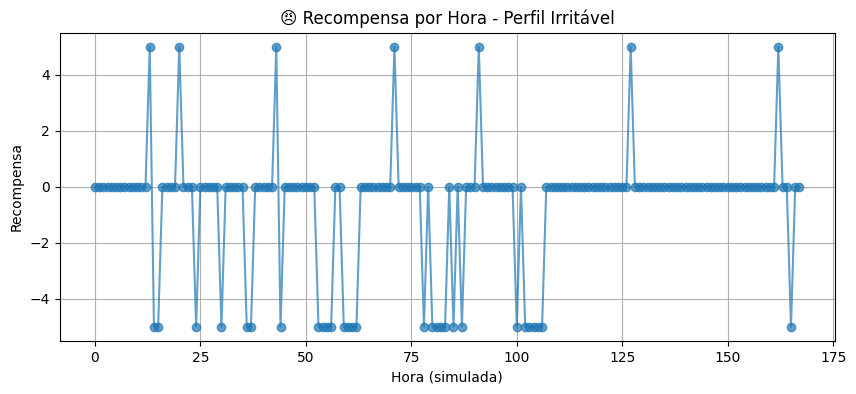

In [ ]:
class PerfilIrritavel(UserAppEnv):
    def reset(self, *args, **kwargs):
        obs, info = super().reset(*args, **kwargs)
        self.notificacoes_hoje = 0
        return obs, info

    def _usuario_abriu_app(self):
        return self.notificacoes_hoje < 2

    def step(self, action):
        reward = 0
        self.notificado = 0

        if action == 1:
            self.notificado = 1
            self.notificacoes_hoje += 1
            if self._usuario_abriu_app():
                reward = 5
            else:
                reward = -5

        self._update_user_state()
        self.passos += 1
        self.hora += 1

        if self.hora >= 24:
            self.hora = 0
            self.dia = (self.dia + 1) % 7
            self.notificacoes_hoje = 0

        terminated = self.passos >= 24 * 7
        truncated = False
        return self._get_obs(), reward, terminated, truncated, {}

env_irritavel = PerfilIrritavel()
obs, _ = env_irritavel.reset()
rewards = []

for _ in range(7 * 24):
    action, _ = model.predict(obs)
    obs, reward, terminated, _, _ = env_irritavel.step(action)
    rewards.append(reward)
    if terminated:
        break

plt.figure(figsize=(10, 4))
plt.plot(rewards, marker='o', alpha=0.7)
plt.title("😠 Recompensa por Hora - Perfil Irritável")
plt.xlabel("Hora (simulada)")
plt.ylabel("Recompensa")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


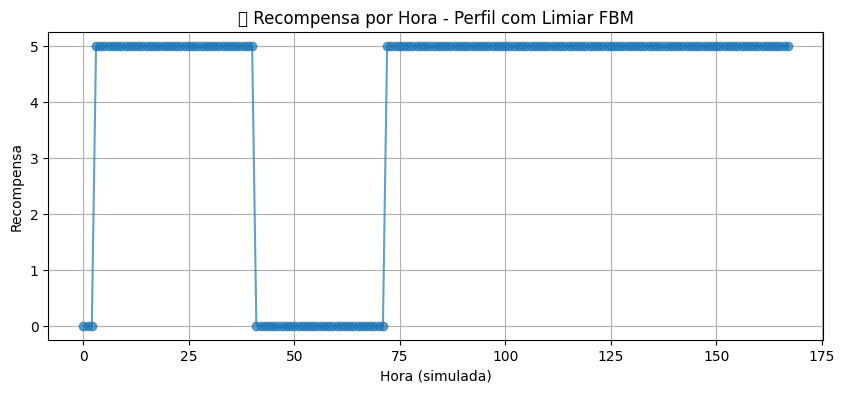

In [ ]:
class PerfilFBMLimiar(UserAppEnv):
    def _usuario_abriu_app(self):
        return self.motivacao * self.habilidade >= 2

env_fbm = PerfilFBMLimiar()
obs, _ = env_fbm.reset()
rewards = []

for _ in range(7 * 24):
    action, _ = model.predict(obs)
    obs, reward, terminated, _, _ = env_fbm.step(action)
    rewards.append(reward)
    if terminated:
        break

plt.figure(figsize=(10, 4))
plt.plot(rewards, marker='o', alpha=0.7)
plt.title("🧠 Recompensa por Hora - Perfil com Limiar FBM")
plt.xlabel("Hora (simulada)")
plt.ylabel("Recompensa")
plt.grid(True)
plt.show()
